In [2]:
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS, HMC
import seaborn as sns
from torch.distributions import MultivariateNormal
import pickle
import numpy as np
import os

In [ ]:
def exact_posterior(x_, y_, sigma_likelihood, sigma_prior):
    x_ = x_.reshape(-1, 1)
    cov = torch.inverse(torch.matmul(x_.T, x_) / sigma_likelihood ** 2 + torch.eye(x_.shape[1]) / sigma_prior ** 2)
    mean = torch.matmul(cov, torch.matmul(x_.T, y_)) / sigma_likelihood ** 2
    return MultivariateNormal(mean, covariance_matrix=cov)


def G(inp):
    # Corresponds to G(x, w) from the notes, exact underlying model
    # this might come from the solution of PDE, for example
    x = inp[:, 0]
    w = inp[:, 1]
    g = x*w
    return g


def generate_measurements(n):
    # Measurements are generated by perturbing the exact model:
    # u = G(x,w) + eta, G(x,w) = wx, w = 1.2, x in [0, 1], eta ~ N(0, sigma_l)
    torch.manual_seed(42)
    sigma_l = torch.tensor(0.1)
    w_ex = torch.tensor(1.2)
    x_obs = torch.rand((n,1)) # x_i, i=1,...,n
    w_ex = w_ex.expand(n, 1)
    inputs = torch.cat([x_obs, w_ex], 1)
    eta = sigma_l*torch.randn((n,))
    u_obs = G(inputs) + eta # u_i, i=1,...,n
    return x_obs, u_obs

In [ ]:
# Generate the data, we are going to infer w (compute its posterior) from these data
measured_data_input, measured_data_output  = generate_measurements(100)
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.scatter(measured_data_input, measured_data_output)
plt.xlabel("x")
plt.ylabel("u")
plt.show()

In [ ]:
# Define the prior and the likelihood according to pyro syntax
mu_prior = 0.
sigma_prior = 10
sigma_likelihood = 0.1

def model(x_observed, u_observed):
    # Prior is a gaussian distriubtion with mean 0 and standard deviation 0.1
    prior_w = dist.Normal(mu_prior, sigma_prior)
    # Sample from the prior
    w = pyro.sample("w", prior_w)
    w = w.expand(x_observed.shape[0], 1)
    # Data likelihood is a gaussian distriubtion with mean G(x,w)=wx and standard deviation 0.1
    inputs = torch.cat([x_observed, w], 1)
    mean = G(inputs)
    #sigma_likelihood = G(inputs)
    #print(mean,sigma_likelihood)
    likelihood = dist.Normal(mean, sigma_likelihood)
    # Sample from the likelihood
    u_sampled = pyro.sample("obs", likelihood, obs=u_observed)



In [8]:
n_samples = 10000
nuts_kernel = NUTS(model)
posterior = MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=1000, initial_params={"w": torch.tensor(mu_prior)})
posterior.run(measured_data_input,measured_data_output)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}

Sample: 100%|██████████| 11000/11000 [00:40, 268.61it/s, step size=1.17e+00, acc. prob=0.898]


In [9]:
exact_post = exact_posterior(measured_data_input, measured_data_output,sigma_likelihood=sigma_likelihood, sigma_prior=sigma_prior )
exact_post_samples = exact_post.sample((10000000,))
print(exact_post.stddev)

tensor([0.0169])


/home/diego/Studies/Uni/DLSC/deep_learning_in_scientific_computing/venv_old/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/diego/Studies/Uni/DLSC/deep_learning_in_scientific_computing/venv_old/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'MCMC Trace')

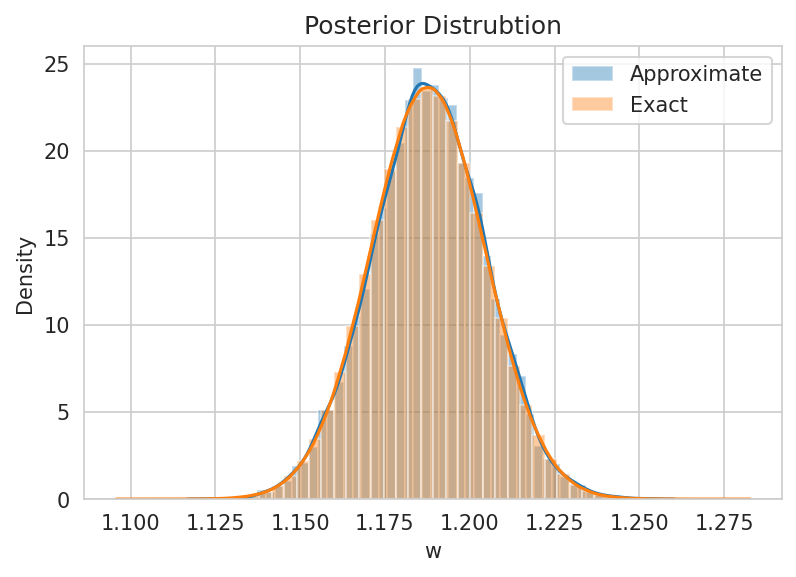

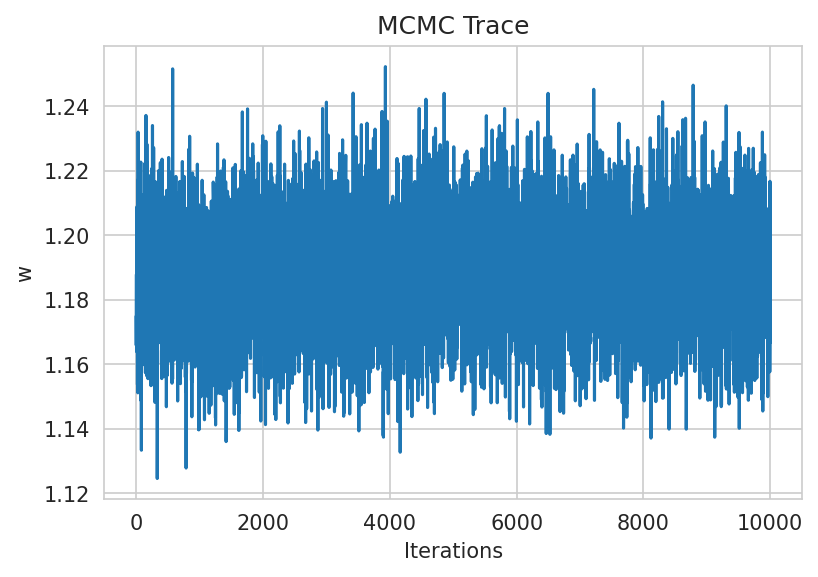

In [10]:
plt.figure(dpi=150)
sns.distplot(hmc_samples["w"], label="Approximate", norm_hist=True)
sns.distplot(exact_post_samples, label="Exact", norm_hist=True)
plt.xlabel("w")
plt.title("Posterior Distrubtion")
plt.legend()
plt.figure(dpi=150)
plt.plot(np.arange(0, hmc_samples["w"].shape[0]), hmc_samples["w"], label="MCMC")
plt.ylabel("w")
plt.xlabel("Iterations")
plt.title("MCMC Trace")